In [1]:
# Import Libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import KFold
from scipy.spatial.distance import cdist

%matplotlib inline

In [2]:
# Read in the data
df = pd.read_csv('https://github.com/doski-codes/bpnn-ngsim-congestion/blob/master/datasets/NGSIM_US101.csv?raw=true')

In [3]:
df.head()

,Unnamed: 0,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Congestion
0,0,515,2330.0,1123.0,1.118848e+12,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2.0,23.31,2.05,3.0,500.0,523.0,119.10,5.11,0
1,1,515,2330.0,1123.0,1.118848e+12,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2.0,23.31,2.05,3.0,500.0,523.0,119.10,5.11,0
2,3,2127,6459.0,567.0,1.118848e+12,19.632,1775.614,6452425.122,1872172.475,13.5,6.9,2.0,37.52,11.20,2.0,2124.0,2132.0,48.92,1.30,0
3,4,1033,4827.0,592.0,1.118848e+12,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,2.0,41.99,0.10,1.0,1029.0,1040.0,38.81,0.92,0
4,5,1033,4827.0,592.0,1.118848e+12,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,2.0,41.99,0.10,1.0,1029.0,1040.0,38.81,0.92,0


In [4]:
df.drop(columns=['Unnamed: 0', 'Congestion'], inplace=True)

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.dropna(inplace=True)

In [7]:
df.describe()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway
count,455846.000000,455846.000000,455846.000000,4.558460e+05,455846.000000,455846.000000,4.558460e+05,4.558460e+05,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000
mean,1335.086031,5296.503345,739.689195,1.118848e+12,29.741326,1043.131800,6.451849e+06,1.872668e+06,15.309449,6.296412,2.016080,30.119328,0.159670,2.991453,1272.369618,1276.829528,67.275576,191.713501
std,788.495635,2664.308538,204.465991,7.693255e+05,16.588804,603.410021,4.511053e+02,4.008011e+02,4.488224,0.892994,0.162736,14.070791,4.550935,1.459117,815.509491,817.265165,41.049844,1360.754989
min,1.000000,10.000000,160.000000,1.118847e+12,0.369000,3.051000,6.451067e+06,1.871889e+06,4.000000,2.000000,1.000000,0.000000,-11.200000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,668.000000,2981.000000,568.000000,1.118848e+12,17.607000,521.866000,6.451455e+06,1.872329e+06,13.500000,5.900000,2.000000,20.000000,-0.770000,2.000000,571.000000,574.000000,43.430000,1.670000
50%,1321.000000,5535.000000,738.000000,1.118849e+12,29.780000,1003.489500,6.451817e+06,1.872690e+06,15.000000,6.400000,2.000000,30.240000,0.000000,3.000000,1259.000000,1262.000000,59.660000,2.280000
75%,1901.000000,7645.000000,904.000000,1.118849e+12,41.767750,1553.459000,6.452230e+06,1.873010e+06,16.000000,6.900000,2.000000,39.990000,1.380000,4.000000,1868.000000,1873.000000,82.580000,3.190000
max,3109.000000,10000.000000,1328.000000,1.118850e+12,75.682000,2217.411000,6.452733e+06,1.873401e+06,76.100000,8.500000,3.000000,95.300000,11.200000,8.000000,3109.000000,3109.000000,771.160000,9999.990000


In [8]:
df['Global_Time'] = pd.to_datetime(df['Global_Time'], unit='ms').dt.tz_localize('GMT').dt.tz_convert('US/Pacific')

In [9]:
df['Hours'] = df.Global_Time.dt.hour / 24
df['Minutes'] = df.Global_Time.dt.minute / 60

In [10]:
df.head()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Hours,Minutes
0,515,2330.0,1123.0,2005-06-15 08:07:55-07:00,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2.0,23.31,2.05,3.0,500.0,523.0,119.10,5.11,0.333333,0.116667
2,2127,6459.0,567.0,2005-06-15 08:00:24.800000-07:00,19.632,1775.614,6452425.122,1872172.475,13.5,6.9,2.0,37.52,11.20,2.0,2124.0,2132.0,48.92,1.30,0.333333,0.000000
3,1033,4827.0,592.0,2005-06-15 08:12:04.700000-07:00,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,2.0,41.99,0.10,1.0,1029.0,1040.0,38.81,0.92,0.333333,0.200000
5,1890,9157.0,628.0,2005-06-15 08:34:32.700000-07:00,53.514,817.521,6451655.238,1872800.663,24.0,8.5,3.0,45.12,-0.55,5.0,1882.0,1897.0,102.65,2.27,0.333333,0.566667
6,744,3392.0,996.0,2005-06-15 08:09:41.200000-07:00,28.878,490.086,6451422.353,1873041.018,15.0,5.9,2.0,24.54,-0.04,3.0,740.0,752.0,37.80,1.54,0.333333,0.150000


In [11]:
global_time = df.Global_Time

In [12]:
df_ = df.drop(columns='Global_Time')

In [13]:
data_ = df_.iloc[:, 2:]

In [14]:
data = data_.drop(columns=['Preceding', 'Following', 'Local_X', 'Local_Y'])

In [15]:
data.reset_index(inplace=True, drop=True)

In [16]:
data.head()

,Total_Frames,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Space_Headway,Time_Headway,Hours,Minutes
0,1123.0,6451203.729,1873252.549,13.0,6.9,2.0,23.31,2.05,3.0,119.10,5.11,0.333333,0.116667
1,567.0,6452425.122,1872172.475,13.5,6.9,2.0,37.52,11.20,2.0,48.92,1.30,0.333333,0.000000
2,592.0,6452347.673,1872258.452,13.5,4.4,2.0,41.99,0.10,1.0,38.81,0.92,0.333333,0.200000
3,628.0,6451655.238,1872800.663,24.0,8.5,3.0,45.12,-0.55,5.0,102.65,2.27,0.333333,0.566667
4,996.0,6451422.353,1873041.018,15.0,5.9,2.0,24.54,-0.04,3.0,37.80,1.54,0.333333,0.150000


# Clustering

In [17]:
data.columns

Index(['Total_Frames', 'Global_X', 'Global_Y', 'v_length', 'v_Width',
       'v_Class', 'v_Vel', 'v_Acc', 'Lane_ID', 'Space_Headway', 'Time_Headway',
       'Hours', 'Minutes'],
      dtype='object')

In [18]:
num_cols = ['Total_Frames', 'v_Vel', 'v_Acc', 'Space_Headway', 'Time_Headway', 'Global_X', 'Global_Y', 'v_length', 'v_Width']

In [19]:
cat_cols = ['v_Class', 'Lane_ID']

In [20]:
for col in cat_cols:
  data[col] = LabelEncoder().fit_transform(data[col])

In [21]:
clus_df = normalize(data)

In [22]:
clustering_df = pd.DataFrame(clus_df, columns=data.columns)

In [23]:
clustering_df.head()

,Total_Frames,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Space_Headway,Time_Headway,Hours,Minutes
0,0.000167,0.960333,0.278854,0.000002,1.027142e-06,1.488611e-07,0.000003,3.051653e-07,2.977222e-07,0.000018,7.606803e-07,4.962037e-08,1.736713e-08
1,0.000084,0.960391,0.278658,0.000002,1.027008e-06,1.488418e-07,0.000006,1.667028e-06,1.488418e-07,0.000007,1.934943e-07,4.961393e-08,0.000000e+00
2,0.000088,0.960386,0.278672,0.000002,6.549088e-07,1.488429e-07,0.000006,1.488429e-08,0.000000e+00,0.000006,1.369355e-07,4.961430e-08,2.976858e-08
3,0.000093,0.960357,0.278774,0.000004,1.265262e-06,2.977086e-07,0.000007,-8.186986e-08,5.954172e-07,0.000015,3.378993e-07,4.961810e-08,8.435077e-08
4,0.000148,0.960344,0.278817,0.000002,8.782608e-07,1.488578e-07,0.000004,-5.954311e-09,2.977155e-07,0.000006,2.292410e-07,4.961926e-08,2.232867e-08


In [24]:
pca_cluster = PCA(n_components = 6, random_state=135).fit_transform(clustering_df)

In [25]:
pca_cluster = pd.DataFrame(pca_cluster)

### Picking number of clusters

In [26]:
pca_cluster_ = PCA(n_components = 2, random_state=135).fit_transform(clustering_df)

In [27]:
pca_cluster_ = pd.DataFrame(pca_cluster_)

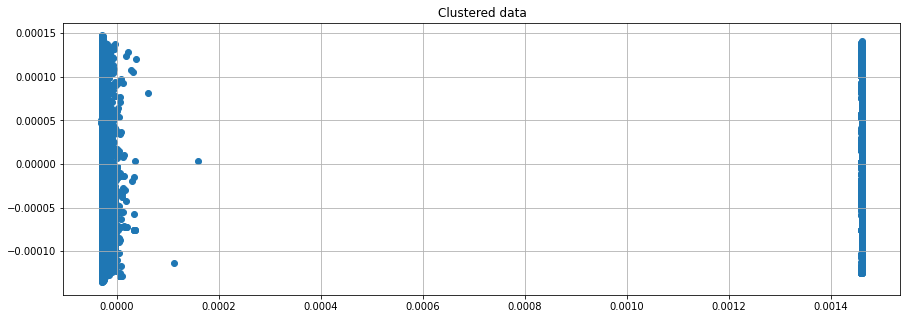

In [28]:
fig = plt.figure(figsize=(15, 5))
plt.scatter(pca_cluster_.iloc[:, 0], pca_cluster_.iloc[:, 1])
plt.grid(True)
plt.title('Clustered data')
plt.show()

In [29]:
kmeans3 = KMeans(n_clusters=2).fit(pca_cluster_)

In [30]:
colours = {0:'red', 1:'yellow', 2:'green'}

In [31]:
kmeans3 = pd.Series(kmeans3.labels_).replace(colours)

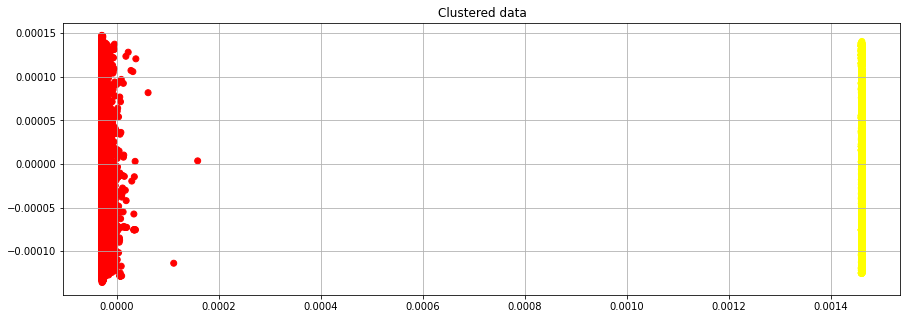

In [32]:
fig = plt.figure(figsize=(15, 5))
plt.scatter(pca_cluster_.iloc[:, 0], pca_cluster_.iloc[:, 1], c=kmeans3)
plt.grid(True)
plt.title('Clustered data')
plt.show()

#### Non PCA cluster check

In [33]:
wss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i).fit(clustering_df)
    wss.append(kmeans.inertia_)

In [34]:
wss

[0.021775407944005596,
 0.0030678793084141067,
 0.0011393760067063797,
 0.0007695194997420966,
 0.0006416358580001405,
 0.0005418596995277341,
 0.0004612260100353322,
 0.00039555951375335764,
 0.0003465353034874292,
 0.00031325972732206426]

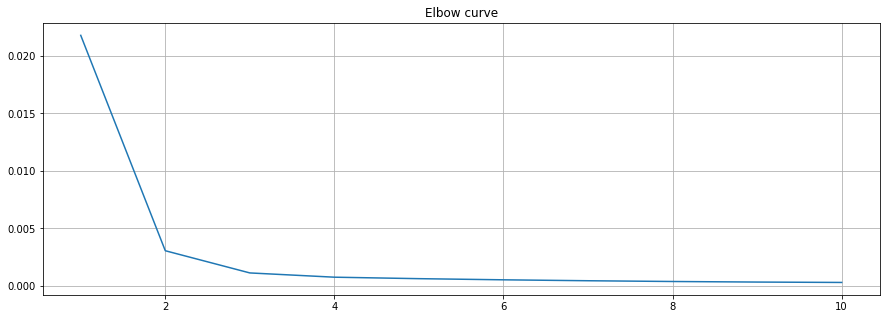

In [35]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 11), wss)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [36]:
elbows = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i).fit(clustering_df)
    elbows.append(sum(np.min(cdist(clustering_df, kmeans.cluster_centers_, 'euclidean'), axis=1)) / clustering_df.shape[0])

In [37]:
elbows

[0.00010704507156074744,
 7.431657478239353e-05,
 4.634533294584995e-05,
 3.7806441257717055e-05,
 3.4071198546841104e-05,
 3.114499815722979e-05,
 2.87594135720831e-05,
 2.6599655187221985e-05,
 2.4773383963913224e-05,
 2.3421158329385953e-05]

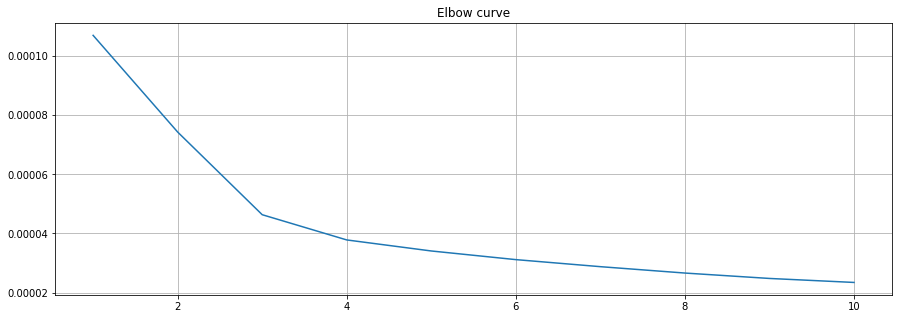

In [38]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 11), elbows)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [39]:
db_index = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i).fit(clustering_df)
    db_index.append(metrics.davies_bouldin_score(clustering_df, kmeans.labels_))

In [40]:
db_index

[0.09235212095400042,
 0.4910408888647472,
 0.6570199783165585,
 0.8270986188186574,
 0.7924100853244225,
 0.7984809463132024,
 0.8123613232457056,
 0.8076182304601603,
 0.7651448542781021]

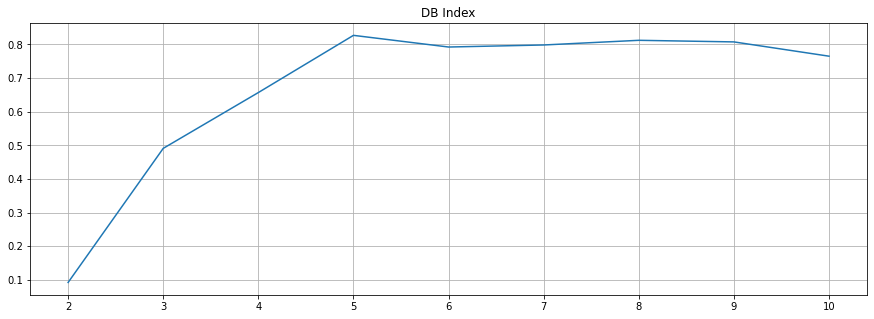

In [41]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 11), db_index)
plt.grid(True)
plt.title('DB Index')
plt.show()

#### PCA cluster check

In [42]:
wss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i).fit(pca_cluster)
    wss.append(kmeans.inertia_)

In [43]:
wss

[0.02177518199498487,
 0.00306765335939351,
 0.0011391650814039072,
 0.0007693469759409808,
 0.000641430208546492,
 0.0005417658595022765,
 0.00046118511855879757,
 0.0003954813454561895,
 0.00034656441891923627,
 0.00031299054881148044]

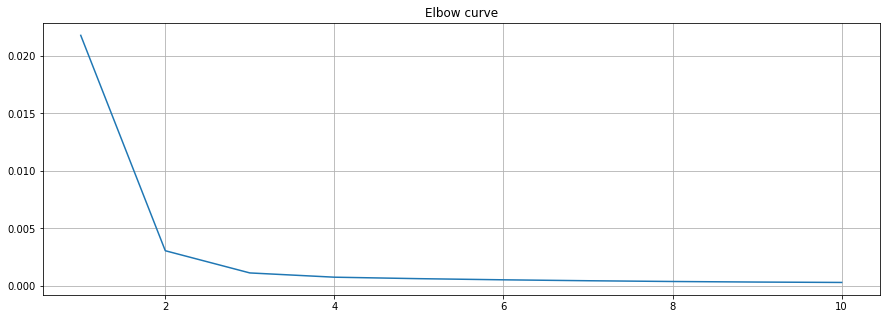

In [44]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 11), wss)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [45]:
elbows = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i).fit(pca_cluster)
    elbows.append(sum(np.min(cdist(pca_cluster, kmeans.cluster_centers_, 'euclidean'), axis=1)) / pca_cluster.shape[0])

In [46]:
elbows

[0.00010704146881541205,
 7.43119041708423e-05,
 4.634112706471088e-05,
 3.780726264100502e-05,
 3.406578827411938e-05,
 3.1140012768724964e-05,
 2.8656367177325723e-05,
 2.658596925161915e-05,
 2.4765937420405837e-05,
 2.3407955411914684e-05]

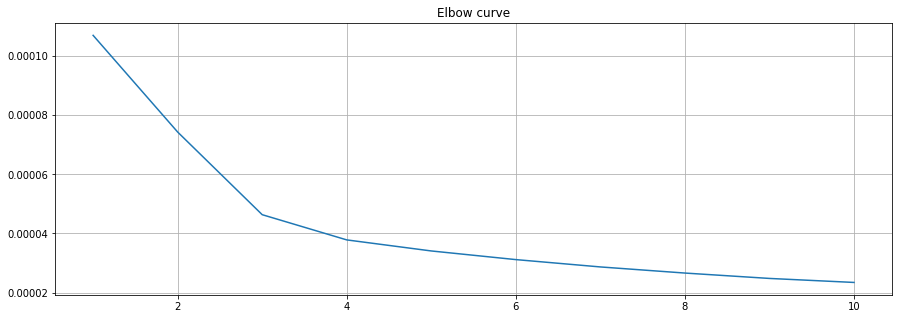

In [47]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 11), elbows)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [48]:
db_index = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i).fit(pca_cluster)
    db_index.append(metrics.davies_bouldin_score(pca_cluster, kmeans.labels_))

In [49]:
db_index

[0.09234731932353492,
 0.4910833348840294,
 0.6556564152309559,
 0.8279207384046204,
 0.7947728652586319,
 0.8017263005234166,
 0.8137443693874055,
 0.8107864546260009,
 0.7673529400490807]

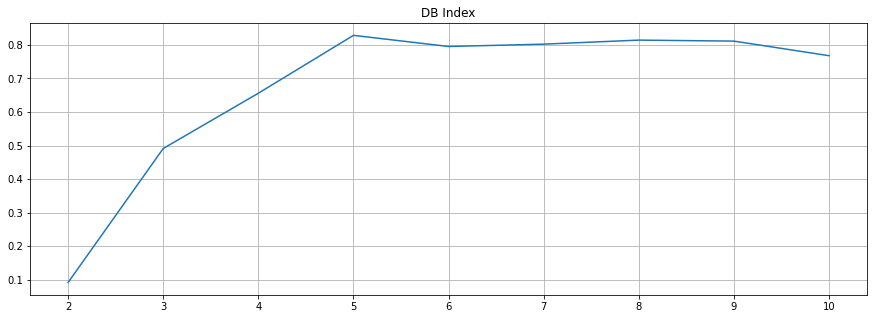

In [50]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 11), db_index)
plt.grid(True)
plt.title('DB Index')
plt.show()

Lowest DB Index values for different PCA components

* PCA = 2, DBI = 0.048504353792782666 for k = 2
* PCA = 3, DBI = 0.05272366033571618 for k = 2
* PCA = 4, DBI = 0.05476090858087586 for k = 2
* PCA = 5, DBI = 0.055203878942769236 for k = 2
* PCA = 6, DBI = 0.05525615815997244 for k = 2
* No PCA, DBI = 0.05525922699731241 for k = 2


### K Means Clustering

In [51]:
kmeans_cluster = KMeans(n_clusters=2, random_state=123).fit(clustering_df)

In [52]:
# Silhouette Score
silhouette_score = metrics.silhouette_score(clustering_df, kmeans_cluster.labels_)
print(silhouette_score)

0.9323558986200222


In [53]:
kmeans_cluster.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [54]:
kmeans_df = df.copy()

In [55]:
kmeans_df['Hours'] = kmeans_df['Hours'] * 24
kmeans_df['Minutes'] = kmeans_df['Minutes'] * 60

In [56]:
kmeans_df['Congestion'] = kmeans_cluster.labels_

In [57]:
kmeans_df['Congestion'].value_counts()

0    447238
1      8608
Name: Congestion, dtype: int64

In [58]:
kmeans_df.head()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Hours,Minutes,Congestion
0,515,2330.0,1123.0,2005-06-15 08:07:55-07:00,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2.0,23.31,2.05,3.0,500.0,523.0,119.10,5.11,8.0,7.0,0
2,2127,6459.0,567.0,2005-06-15 08:00:24.800000-07:00,19.632,1775.614,6452425.122,1872172.475,13.5,6.9,2.0,37.52,11.20,2.0,2124.0,2132.0,48.92,1.30,8.0,0.0,0
3,1033,4827.0,592.0,2005-06-15 08:12:04.700000-07:00,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,2.0,41.99,0.10,1.0,1029.0,1040.0,38.81,0.92,8.0,12.0,0
5,1890,9157.0,628.0,2005-06-15 08:34:32.700000-07:00,53.514,817.521,6451655.238,1872800.663,24.0,8.5,3.0,45.12,-0.55,5.0,1882.0,1897.0,102.65,2.27,8.0,34.0,0
6,744,3392.0,996.0,2005-06-15 08:09:41.200000-07:00,28.878,490.086,6451422.353,1873041.018,15.0,5.9,2.0,24.54,-0.04,3.0,740.0,752.0,37.80,1.54,8.0,9.0,0


In [59]:
kmeans_df.describe()

,Vehicle_ID,Frame_ID,Total_Frames,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Hours,Minutes,Congestion
count,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,4.558460e+05,4.558460e+05,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000
mean,1335.086031,5296.503345,739.689195,29.741326,1043.131800,6.451849e+06,1.872668e+06,15.309449,6.296412,2.016080,30.119328,0.159670,2.991453,1272.369618,1276.829528,67.275576,191.713501,7.833319,24.158093,0.018884
std,788.495635,2664.308538,204.465991,16.588804,603.410021,4.511053e+02,4.008011e+02,4.488224,0.892994,0.162736,14.070791,4.550935,1.459117,815.509491,817.265165,41.049844,1360.754989,0.372691,16.528372,0.136114
min,1.000000,10.000000,160.000000,0.369000,3.051000,6.451067e+06,1.871889e+06,4.000000,2.000000,1.000000,0.000000,-11.200000,1.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000
25%,668.000000,2981.000000,568.000000,17.607000,521.866000,6.451455e+06,1.872329e+06,13.500000,5.900000,2.000000,20.000000,-0.770000,2.000000,571.000000,574.000000,43.430000,1.670000,8.000000,11.000000,0.000000
50%,1321.000000,5535.000000,738.000000,29.780000,1003.489500,6.451817e+06,1.872690e+06,15.000000,6.400000,2.000000,30.240000,0.000000,3.000000,1259.000000,1262.000000,59.660000,2.280000,8.000000,22.000000,0.000000
75%,1901.000000,7645.000000,904.000000,41.767750,1553.459000,6.452230e+06,1.873010e+06,16.000000,6.900000,2.000000,39.990000,1.380000,4.000000,1868.000000,1873.000000,82.580000,3.190000,8.000000,32.000000,0.000000
max,3109.000000,10000.000000,1328.000000,75.682000,2217.411000,6.452733e+06,1.873401e+06,76.100000,8.500000,3.000000,95.300000,11.200000,8.000000,3109.000000,3109.000000,771.160000,9999.990000,8.000000,59.000000,1.000000


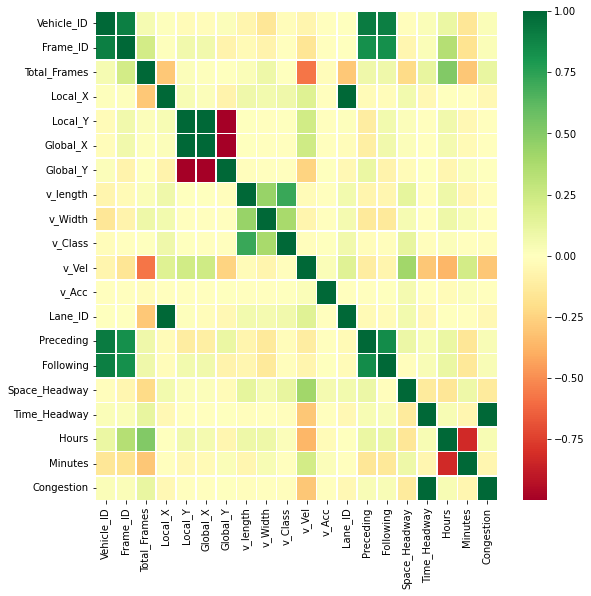

In [60]:
# Heatmap to show the correlation (Pearson's correlation) between the variables
corr = kmeans_df.corr()
plt.figure(figsize=(9,9))
ax = sns.heatmap(corr, linewidth=0.5, cmap='RdYlGn')

In [61]:
kmeans_df['Global_Time'] = global_time

In [62]:
kmeans_df['Time'] = kmeans_df.Global_Time.dt.strftime('%H:%M:%S')

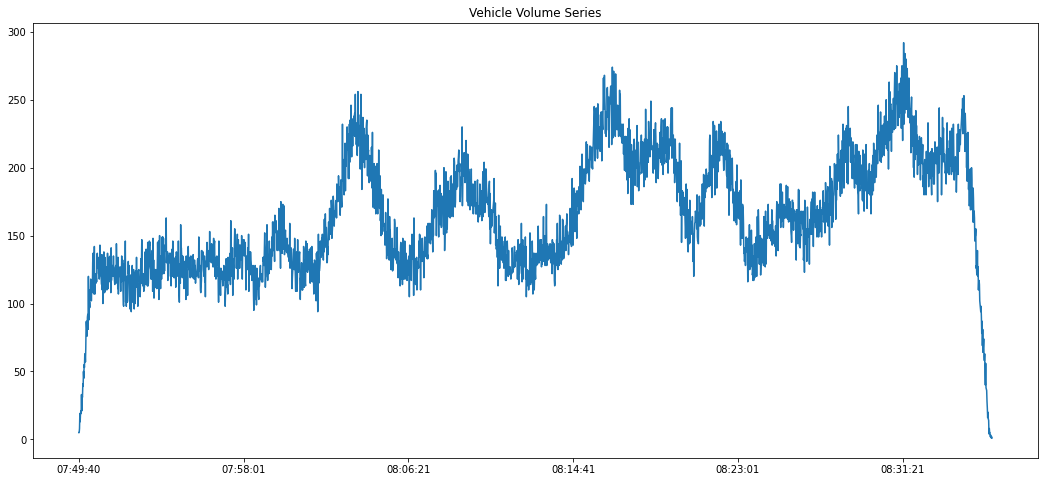

In [63]:
ax = kmeans_df.Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

In [64]:
plot_df = pd.DataFrame(kmeans_df.groupby('Congestion').Time.value_counts())
plot_df.columns = ['Count']
plot_df.reset_index(inplace=True)

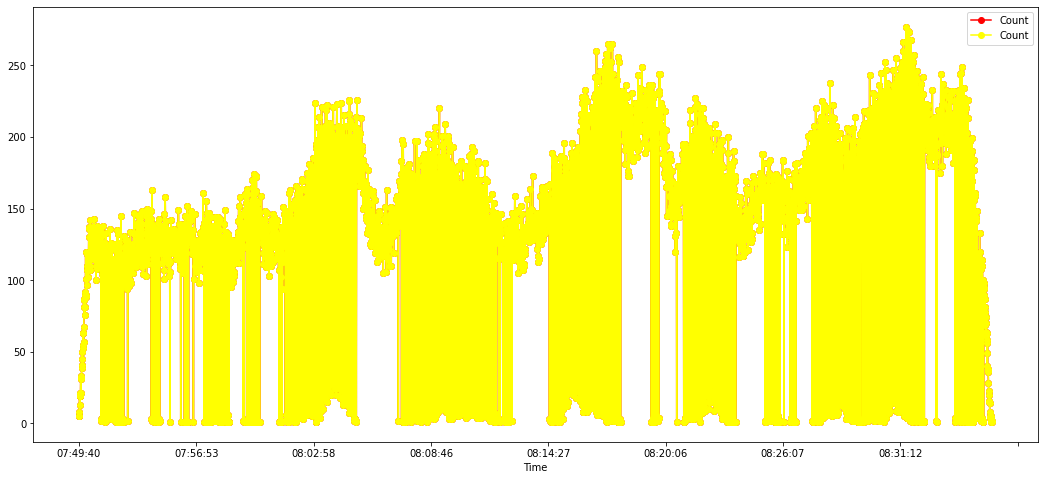

In [65]:
_, ax = plt.subplots(figsize=(18,8))

for congestion, time in plot_df.groupby('Congestion'):
     plot_df.sort_values('Time').plot('Time','Count', marker='o', ax=ax, color=colours[congestion])

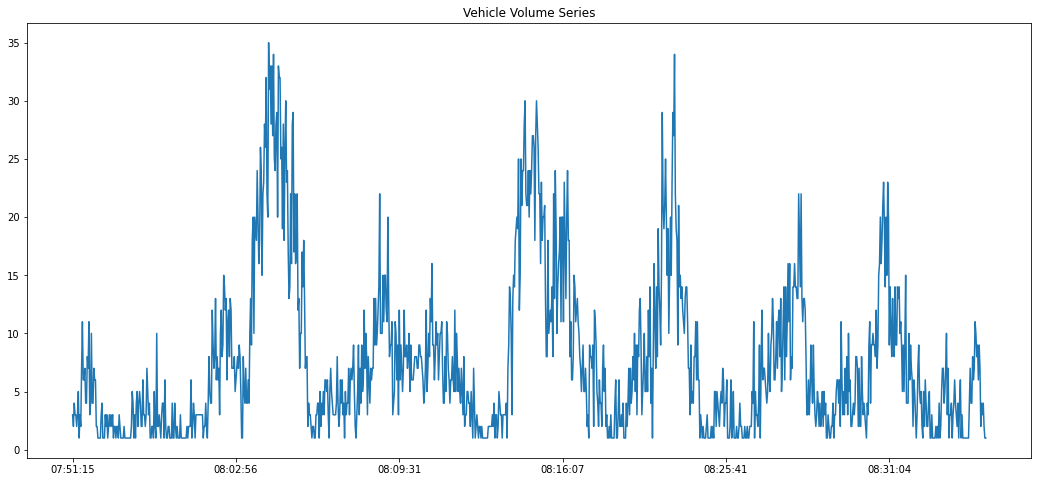

In [66]:
ax = kmeans_df[kmeans_df['Congestion'] == 1].Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

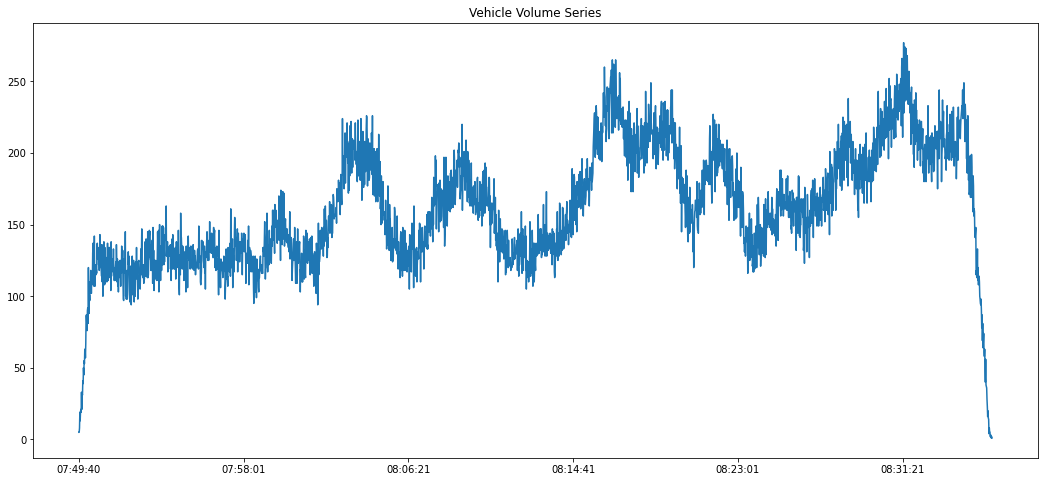

In [67]:
ax = kmeans_df[kmeans_df['Congestion'] == 0].Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

In [68]:
pd.DataFrame(kmeans_df[kmeans_df.Congestion == 1].Time.value_counts()).reset_index().sort_values('index')

,index,Time
807,07:51:15,3
897,07:51:16,2
723,07:51:18,4
745,07:51:19,3
771,07:51:20,3
...,...,...
827,08:35:13,3
662,08:35:14,4
915,08:35:15,2
1022,08:35:16,1


In [69]:
kmeans_df['v_Class'].value_counts()

2.0    443656
3.0      9760
1.0      2430
Name: v_Class, dtype: int64

Vehicle volume time series for the various classes of vehicles

In [70]:
for cls in kmeans_df['v_Class'].unique():
  print(f'Vehicle Class: {cls} \n{kmeans_df[kmeans_df["v_Class"] == cls].Congestion.value_counts()} \n')

Vehicle Class: 2.0 
0    435116
1      8540
Name: Congestion, dtype: int64 

Vehicle Class: 3.0 
0    9707
1      53
Name: Congestion, dtype: int64 

Vehicle Class: 1.0 
0    2415
1      15
Name: Congestion, dtype: int64 



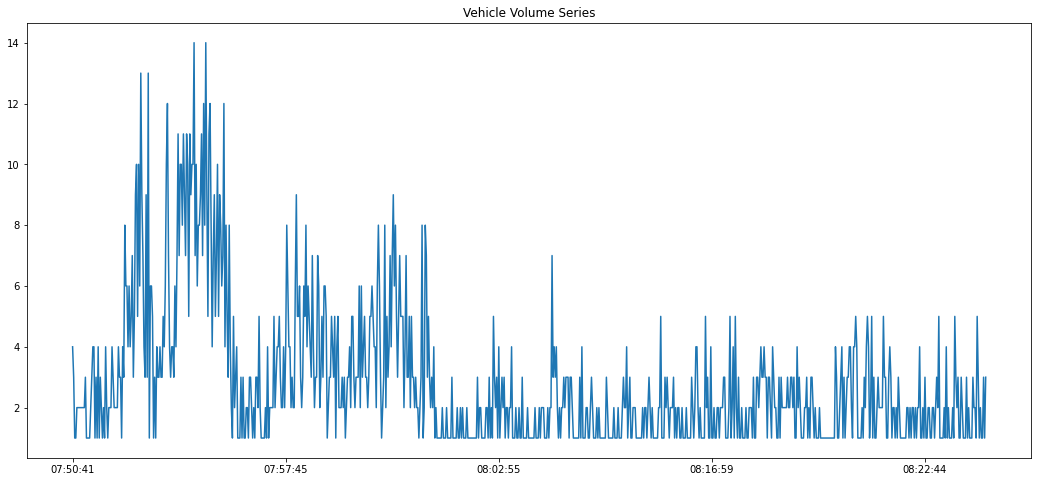

In [71]:
ax = kmeans_df[kmeans_df['v_Class'] == 1].Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

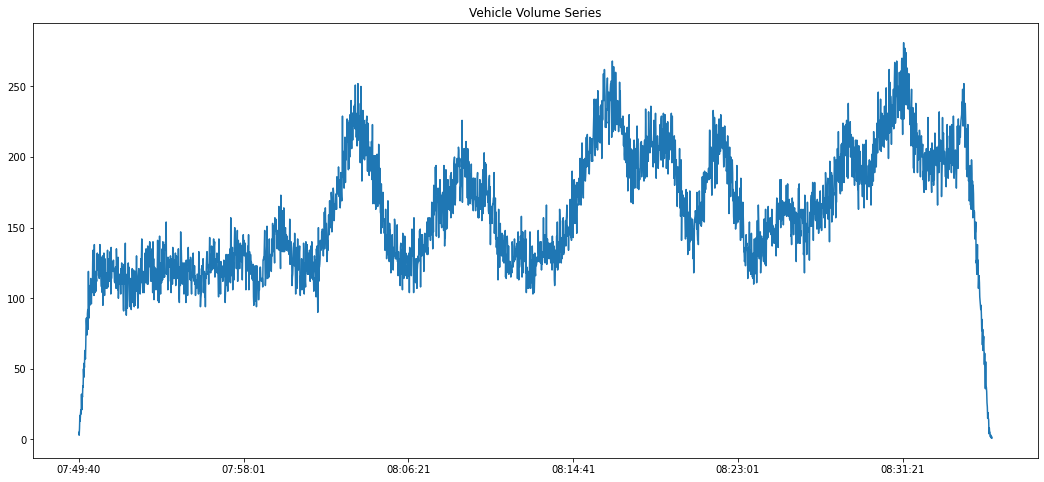

In [72]:
ax = kmeans_df[kmeans_df['v_Class'] == 2].Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

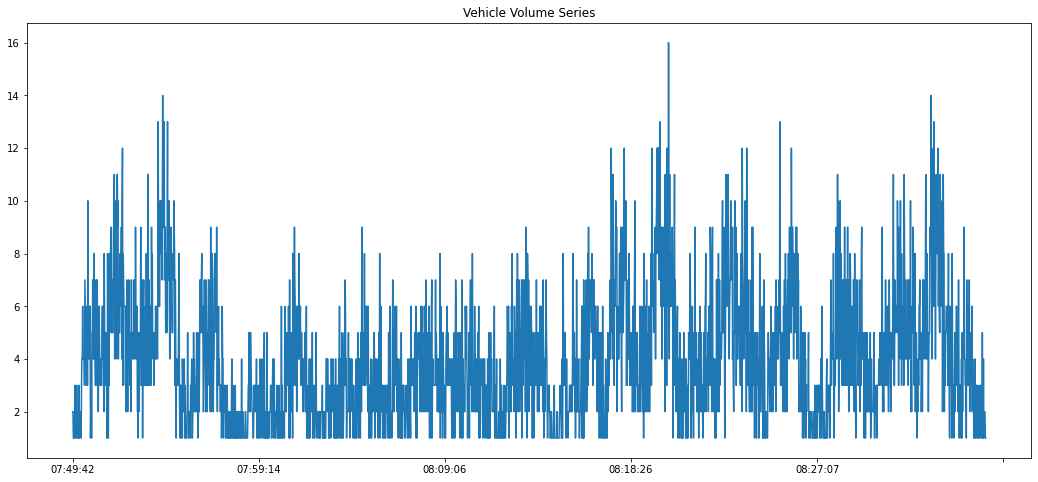

In [73]:
ax = kmeans_df[kmeans_df['v_Class'] == 3].Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

##### KMeans on PCA data

In [74]:
kmeans_pca_cluster = KMeans(n_clusters=2, random_state=123).fit(pca_cluster)

In [75]:
# Silhouette Score
silhouette_score = metrics.silhouette_score(pca_cluster, kmeans_pca_cluster.labels_)
print(silhouette_score)

0.9323609609117348


In [76]:
kmeans_pca_cluster.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [77]:
kmeans_pca_df = df.copy()

In [78]:
kmeans_pca_df['Hours'] = kmeans_pca_df['Hours'] * 24
kmeans_pca_df['Minutes'] = kmeans_pca_df['Minutes'] * 60

In [79]:
kmeans_pca_df['Congestion'] = kmeans_pca_cluster.labels_

In [80]:
kmeans_pca_df['Congestion'].value_counts()

0    447238
1      8608
Name: Congestion, dtype: int64

In [81]:
kmeans_pca_df.head()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Hours,Minutes,Congestion
0,515,2330.0,1123.0,2005-06-15 08:07:55-07:00,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2.0,23.31,2.05,3.0,500.0,523.0,119.10,5.11,8.0,7.0,0
2,2127,6459.0,567.0,2005-06-15 08:00:24.800000-07:00,19.632,1775.614,6452425.122,1872172.475,13.5,6.9,2.0,37.52,11.20,2.0,2124.0,2132.0,48.92,1.30,8.0,0.0,0
3,1033,4827.0,592.0,2005-06-15 08:12:04.700000-07:00,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,2.0,41.99,0.10,1.0,1029.0,1040.0,38.81,0.92,8.0,12.0,0
5,1890,9157.0,628.0,2005-06-15 08:34:32.700000-07:00,53.514,817.521,6451655.238,1872800.663,24.0,8.5,3.0,45.12,-0.55,5.0,1882.0,1897.0,102.65,2.27,8.0,34.0,0
6,744,3392.0,996.0,2005-06-15 08:09:41.200000-07:00,28.878,490.086,6451422.353,1873041.018,15.0,5.9,2.0,24.54,-0.04,3.0,740.0,752.0,37.80,1.54,8.0,9.0,0


In [82]:
kmeans_pca_df.describe()

,Vehicle_ID,Frame_ID,Total_Frames,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Hours,Minutes,Congestion
count,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,4.558460e+05,4.558460e+05,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000
mean,1335.086031,5296.503345,739.689195,29.741326,1043.131800,6.451849e+06,1.872668e+06,15.309449,6.296412,2.016080,30.119328,0.159670,2.991453,1272.369618,1276.829528,67.275576,191.713501,7.833319,24.158093,0.018884
std,788.495635,2664.308538,204.465991,16.588804,603.410021,4.511053e+02,4.008011e+02,4.488224,0.892994,0.162736,14.070791,4.550935,1.459117,815.509491,817.265165,41.049844,1360.754989,0.372691,16.528372,0.136114
min,1.000000,10.000000,160.000000,0.369000,3.051000,6.451067e+06,1.871889e+06,4.000000,2.000000,1.000000,0.000000,-11.200000,1.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000
25%,668.000000,2981.000000,568.000000,17.607000,521.866000,6.451455e+06,1.872329e+06,13.500000,5.900000,2.000000,20.000000,-0.770000,2.000000,571.000000,574.000000,43.430000,1.670000,8.000000,11.000000,0.000000
50%,1321.000000,5535.000000,738.000000,29.780000,1003.489500,6.451817e+06,1.872690e+06,15.000000,6.400000,2.000000,30.240000,0.000000,3.000000,1259.000000,1262.000000,59.660000,2.280000,8.000000,22.000000,0.000000
75%,1901.000000,7645.000000,904.000000,41.767750,1553.459000,6.452230e+06,1.873010e+06,16.000000,6.900000,2.000000,39.990000,1.380000,4.000000,1868.000000,1873.000000,82.580000,3.190000,8.000000,32.000000,0.000000
max,3109.000000,10000.000000,1328.000000,75.682000,2217.411000,6.452733e+06,1.873401e+06,76.100000,8.500000,3.000000,95.300000,11.200000,8.000000,3109.000000,3109.000000,771.160000,9999.990000,8.000000,59.000000,1.000000


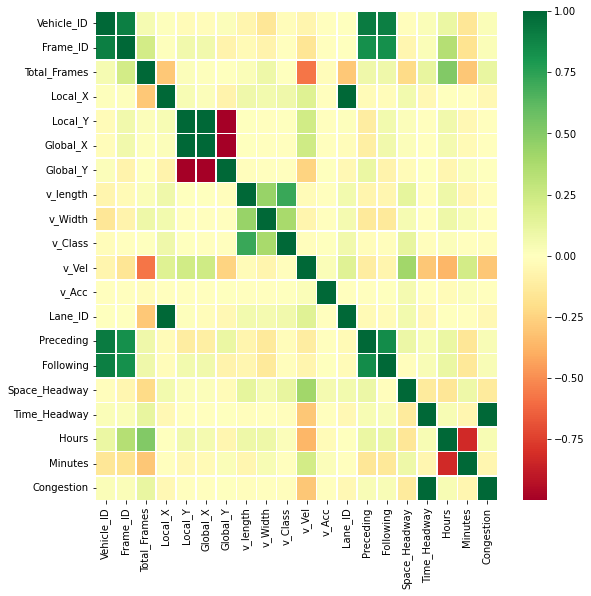

In [83]:
# Heatmap to show the correlation (Pearson's correlation) between the variables
corr = kmeans_pca_df.corr()
plt.figure(figsize=(9,9))
ax = sns.heatmap(corr, linewidth=0.5, cmap='RdYlGn')

In [84]:
kmeans_pca_df['Global_Time'] = global_time

In [85]:
kmeans_pca_df['Time'] = kmeans_pca_df.Global_Time.dt.strftime('%H:%M:%S')

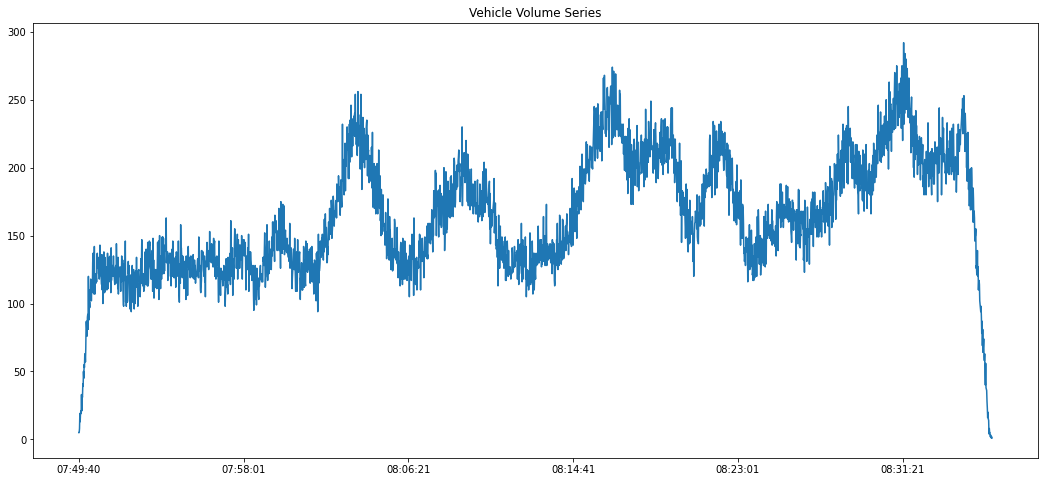

In [86]:
ax = kmeans_pca_df.Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

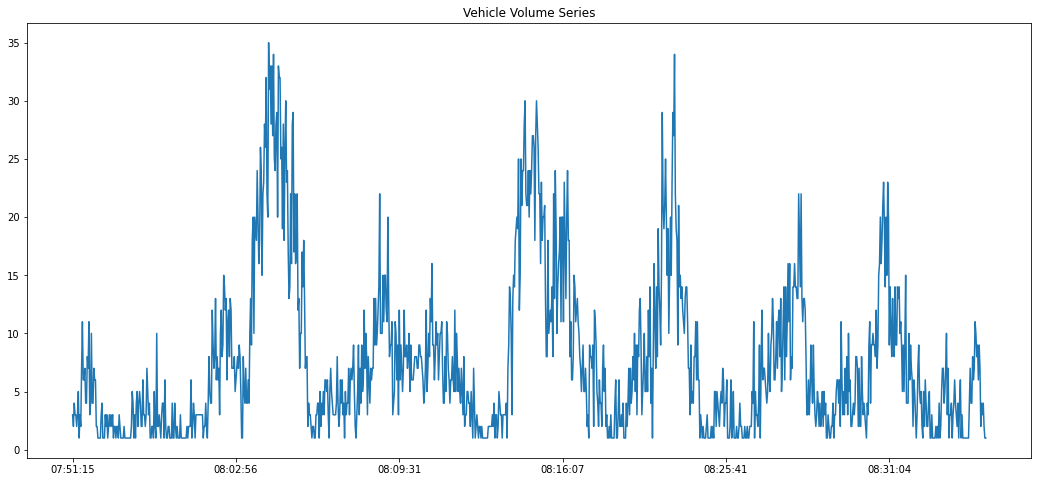

In [87]:
ax = kmeans_pca_df[kmeans_pca_df['Congestion'] == 1].Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

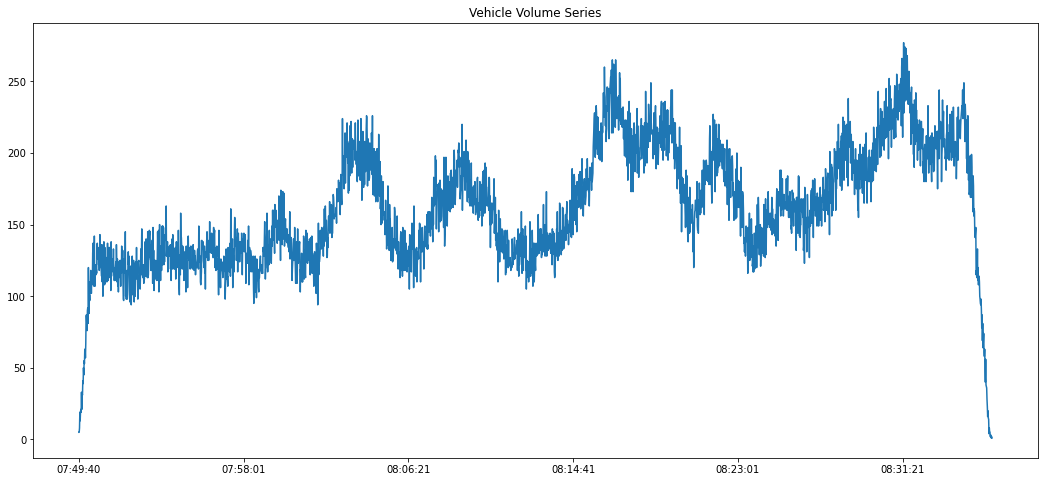

In [88]:
ax = kmeans_pca_df[kmeans_pca_df['Congestion'] == 0].Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

# Save data

In [89]:
df['Congestion'] = kmeans_pca_cluster.labels_

In [90]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455846 entries, 0 to 527909
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype                     
---  ------         --------------   -----                     
 0   Vehicle_ID     455846 non-null  int64                     
 1   Frame_ID       455846 non-null  float64                   
 2   Total_Frames   455846 non-null  float64                   
 3   Global_Time    455846 non-null  datetime64[ns, US/Pacific]
 4   Local_X        455846 non-null  float64                   
 5   Local_Y        455846 non-null  float64                   
 6   Global_X       455846 non-null  float64                   
 7   Global_Y       455846 non-null  float64                   
 8   v_length       455846 non-null  float64                   
 9   v_Width        455846 non-null  float64                   
 10  v_Class        455846 non-null  float64                   
 11  v_Vel          455846 non-null  float64             

In [91]:
df.to_csv('NGSIM_US101_congestion.csv', index=False)

### Agglometric Hierarchical Clustering

In [92]:
# agglo_cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward').fit(pca_cluster)

In [93]:
# agglo_cluster.labels_

In [94]:
# agglo_df = data.iloc[:,:]